In [32]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
import numpy as np
import math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.utils import to_categorical
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from statsmodels.stats.outliers_influence import variance_inflation_factor
from imblearn.over_sampling import SMOTE

ModuleNotFoundError: No module named 'tensorflow.python'

In [33]:
# Function to load data and print data types
def load_data(file_path):
    """
    Load data from the specified file path and handle data types.
    """
    data = pd.read_excel(file_path)
    
    # Convert columns to appropriate data types
    # List of columns that should be numeric
    numeric_columns = ['current_size', 'fire_location_latitude', 'fire_location_longitude',
                       'discovered_size', 'assessment_hectares', 'fire_spread_rate',
                       'temperature', 'relative_humidity', 'wind_speed', 'distance_from_water_source',
                       'bh_hectares', 'uc_hectares', 'to_hectares', 'ex_hectares']

    for col in numeric_columns:
        data[col] = pd.to_numeric(data[col], errors='coerce')  # Convert to numeric, set errors to NaN
    
    # Print data types of all columns
    print(data.dtypes)
    
    return data

def main(file_path):
    """
    Main function to load data and print data types.
    """
    data = load_data(file_path)
    return data

if __name__ == "__main__":
    # Ensure the file path is correctly formatted for your OS
    file_path = r"https://open.alberta.ca/dataset/a221e7a0-4f46-4be7-9c5a-e29de9a3447e/resource/80480824-0c50-456c-9723-f9d4fc136141/download/fp-historical-wildfire-data-2006-2023.xlsx"
    main(file_path)



fire_year                         int64
fire_number                      object
fire_name                        object
current_size                    float64
size_class                       object
fire_location_latitude          float64
fire_location_longitude         float64
fire_origin                      object
general_cause_desc               object
industry_identifier_desc         object
responsible_group_desc           object
activity_class                   object
true_cause                       object
fire_start_date                  object
det_agent_type                   object
det_agent                        object
discovered_date                  object
discovered_size                 float64
reported_date                    object
dispatched_resource              object
dispatch_date                    object
start_for_fire_date              object
assessment_resource              object
assessment_datetime              object
assessment_hectares             float64


In [34]:
data = load_data(file_path)


fire_year                         int64
fire_number                      object
fire_name                        object
current_size                    float64
size_class                       object
fire_location_latitude          float64
fire_location_longitude         float64
fire_origin                      object
general_cause_desc               object
industry_identifier_desc         object
responsible_group_desc           object
activity_class                   object
true_cause                       object
fire_start_date                  object
det_agent_type                   object
det_agent                        object
discovered_date                  object
discovered_size                 float64
reported_date                    object
dispatched_resource              object
dispatch_date                    object
start_for_fire_date              object
assessment_resource              object
assessment_datetime              object
assessment_hectares             float64


If we drop all na values, we end up with no data. So I will start by dropping columns with high missing values percentage.

In [35]:
# Convert date columns to datetime
date_columns = ['fire_start_date', 'discovered_date', 'reported_date', 'start_for_fire_date', 'dispatch_date', 'assessment_datetime','ia_arrival_at_fire_date', 'fire_fighting_start_date', 'first_bucket_drop_date', 'bh_fs_date', 'uc_fs_date', 'to_fs_date', 'ex_fs_date']

## noticed that 'fire_fighting_start_size' was included in error, so I changed it to 'fire_fighting_start_date' - Ray

# Convert each column to datetime
for col in date_columns:
    data[col] = pd.to_datetime(data[col], errors='coerce')

In [36]:
# Create a function to calculate fire_duration (in minutes)
def calculate_fire_duration(row):
    if pd.notnull(row['fire_start_date']):
        return (row['ex_fs_date'] - row['fire_start_date']).total_seconds() / 60
    elif pd.notnull(row['discovered_date']):
        return (row['ex_fs_date'] - row['discovered_date']).total_seconds() / 60
    elif pd.notnull(row['reported_date']):
        return (row['ex_fs_date'] - row['reported_date']).total_seconds() / 60
    else:
        return pd.NaT

# Apply the function row-wise to calculate fire_duration
data['fire_duration'] = data.apply(calculate_fire_duration, axis=1)

In [37]:
# Calculate the correlation between fire_duration and current_size
correlation_value = data['fire_duration'].corr(data['current_size'])

print(f"Correlation between fire_duration and current_size: {correlation_value}, indicating a weak positive linear relationship")

Correlation between fire_duration and current_size: 0.13294338799031138, indicating a weak positive linear relationship


In [38]:
# Create a location column
# Extracting the first letter into a new column 'location'
data['location'] = data['fire_number'].str[0]

# Mapping dictionary for location
location_map = {
    'C': 'Calgary',
    'E': 'Edson',
    'H': 'High Level',
    'G': 'Grande Prairie',
    'L': 'Lac La Biche',
    'M': 'Fort McMurray',
    'P': 'Peace River',
    'R': 'Rocky',
    'S': 'Slave Lake',
    'W': 'Whitecourt'
}

# Replace the values in 'location' column using the mapping dictionary
data['location'].replace(location_map, inplace=True)

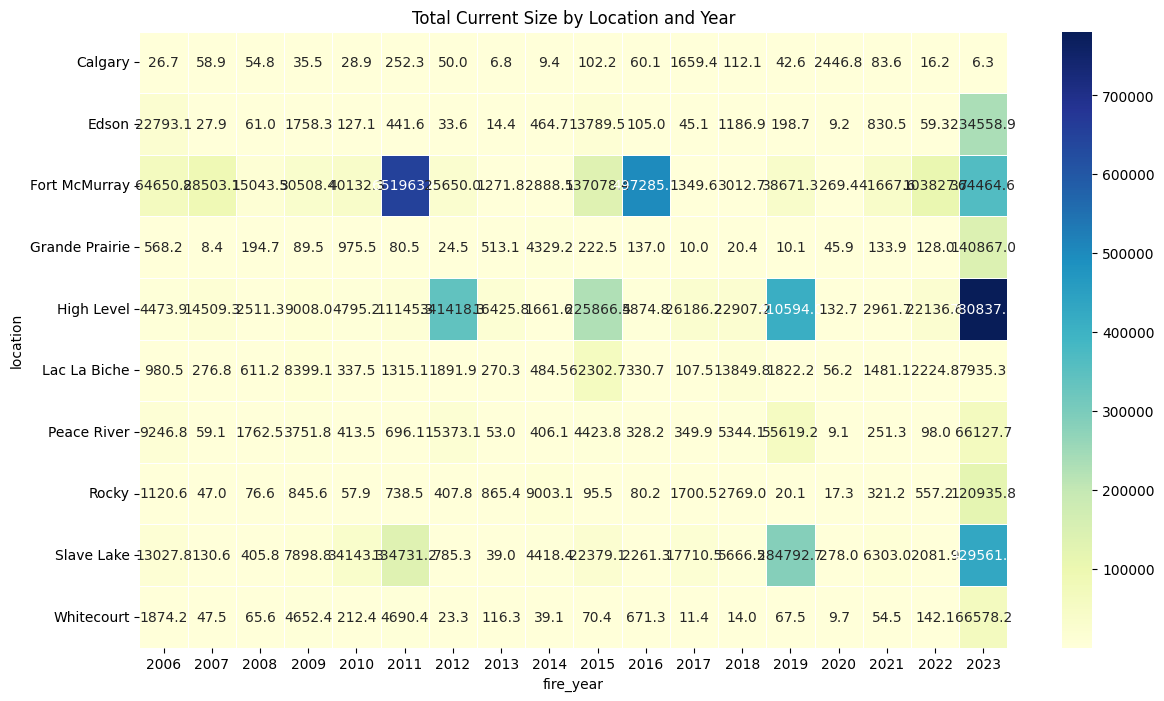

In [39]:
# Group by 'location' and 'fire_year' and calculate the total current_size
grouped_location_year = data.groupby(['location', 'fire_year']).agg({'current_size': 'sum'}).reset_index()

# Pivot the table to get years as columns and locations as rows
pivot_table = grouped_location_year.pivot(index='location', columns='fire_year', values='current_size')

plt.figure(figsize=(14, 8))
sns.heatmap(pivot_table, annot=True, fmt=".1f", cmap="YlGnBu", linewidths=.5)
plt.title('Total Current Size by Location and Year')
plt.show()

Between 2006 and 2023, Fort McMurray, High Level, and Slave Lake experienced the highest amounts of area burned due to wildfires. In 2023, there was a noticeable increase in the size of areas burned across the majority of locations compared to previous years.

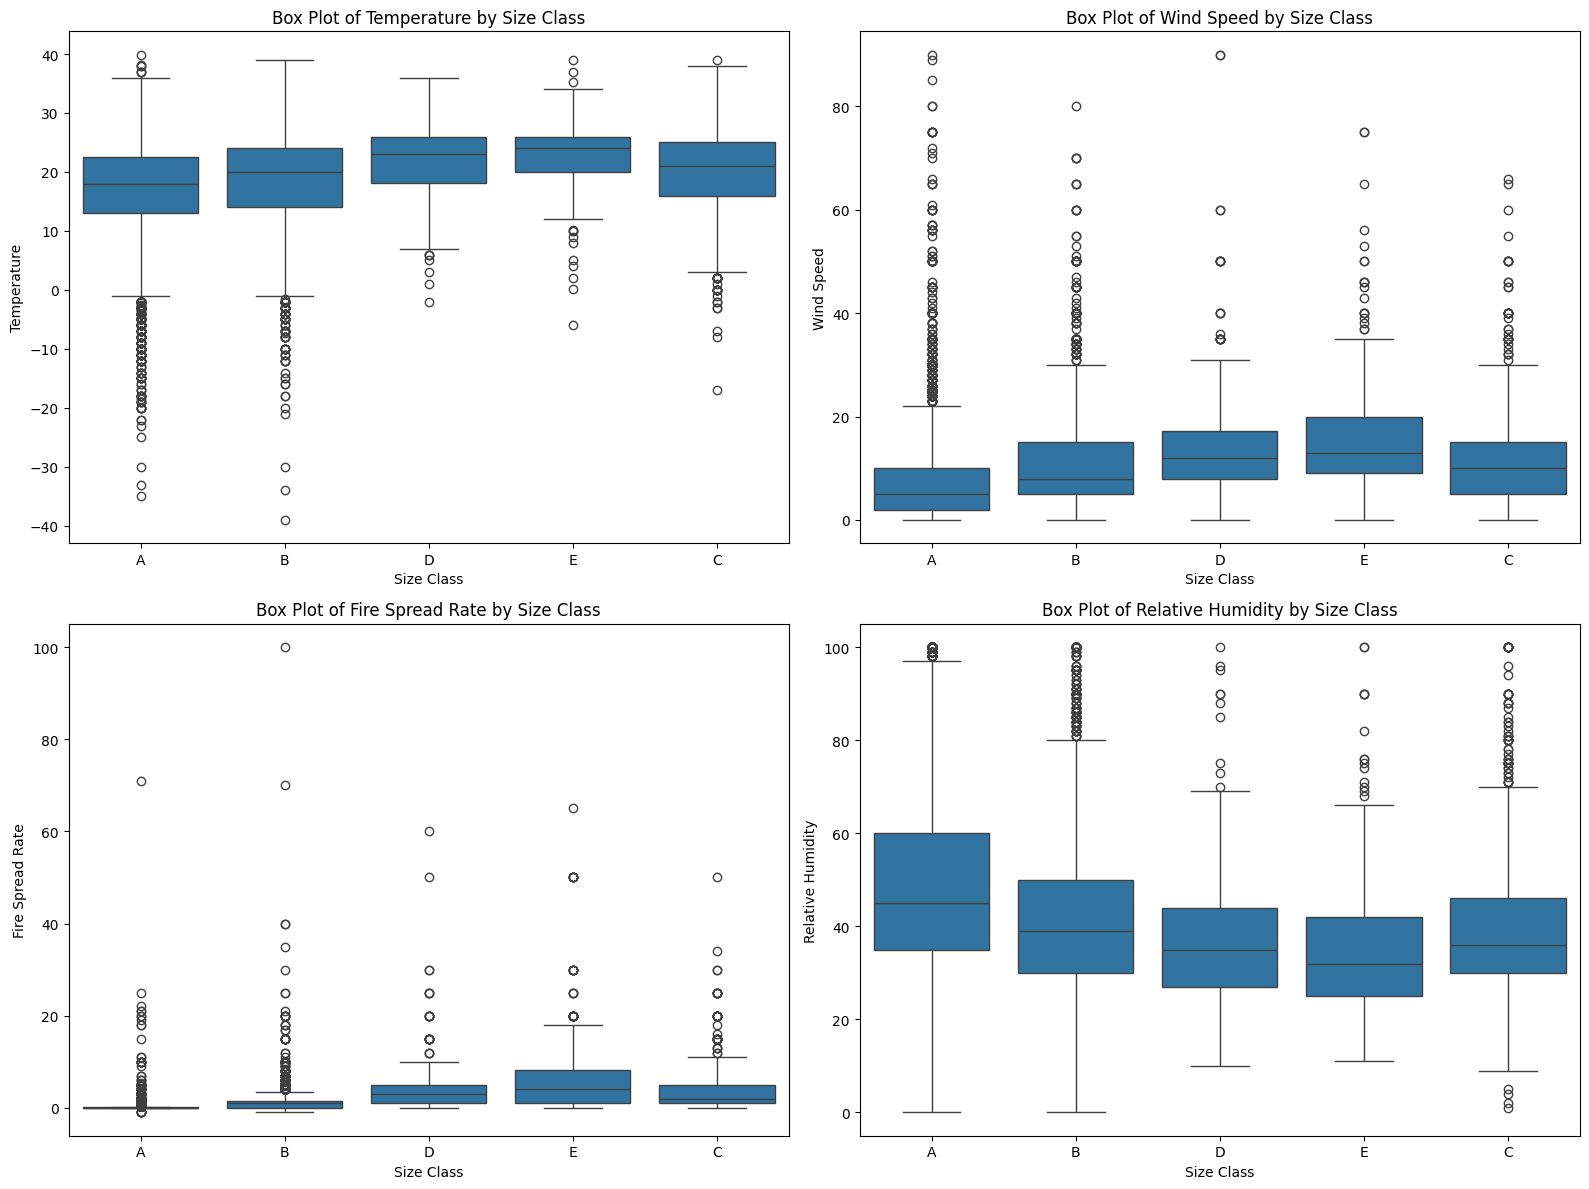

In [40]:
# Create a figure with 4 subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Create a box plot for temperature by size_class
sns.boxplot(x='size_class', y='temperature', data=data, ax=axes[0, 0])
axes[0, 0].set_title('Box Plot of Temperature by Size Class')
axes[0, 0].set_xlabel('Size Class')
axes[0, 0].set_ylabel('Temperature')

# Create a box plot for wind_speed by size_class
sns.boxplot(x='size_class', y='wind_speed', data=data, ax=axes[0, 1])
axes[0, 1].set_title('Box Plot of Wind Speed by Size Class')
axes[0, 1].set_xlabel('Size Class')
axes[0, 1].set_ylabel('Wind Speed')

# Create a box plot for fire_spread_rate by size_class
sns.boxplot(x='size_class', y='fire_spread_rate', data=data, ax=axes[1, 0])
axes[1, 0].set_title('Box Plot of Fire Spread Rate by Size Class')
axes[1, 0].set_xlabel('Size Class')
axes[1, 0].set_ylabel('Fire Spread Rate')

# Create a box plot for relative_humidity by size_class
sns.boxplot(x='size_class', y='relative_humidity', data=data, ax=axes[1, 1])
axes[1, 1].set_title('Box Plot of Relative Humidity by Size Class')
axes[1, 1].set_xlabel('Size Class')
axes[1, 1].set_ylabel('Relative Humidity')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


Additionally, the data reveals a correlation between fire size class and environmental factors such as temperature, wind speed, and relative humidity. Specifically, larger fire size classes (Class E) are associated with higher temperatures, higher wind speeds, and lower humidity levels. However, there are some notable outliers:

Class A and B show variability in temperature and wind speed.
Class B and C display more outliers in terms of relative humidity.
Furthermore, as the fire size class increases, there is a corresponding increase in the fire spread rate. This indicates that larger fires tend to spread more rapidly, influenced by the more extreme environmental conditions they occur under.

Comparison of Total Current Size and Number of Fires by Year:
    fire_year  current_size  count
0        2006     118761.87   1954
1        2007     103668.54   1348
2        2008      20786.91   1712
3        2009      66947.44   1710
4        2010      81223.74   1840
5        2011     806054.64   1218
6        2012     385657.86   1568
7        2013      19575.84   1226
8        2014      23704.53   1470
9        2015     466330.48   1898
10       2016     507134.11   1376
11       2017      49130.33   1244
12       2018      54882.68   1279
13       2019     791838.41   1005
14       2020       3274.45    723
15       2021      54088.58   1342
16       2022     131271.77   1276
17       2023    2211873.23   1132


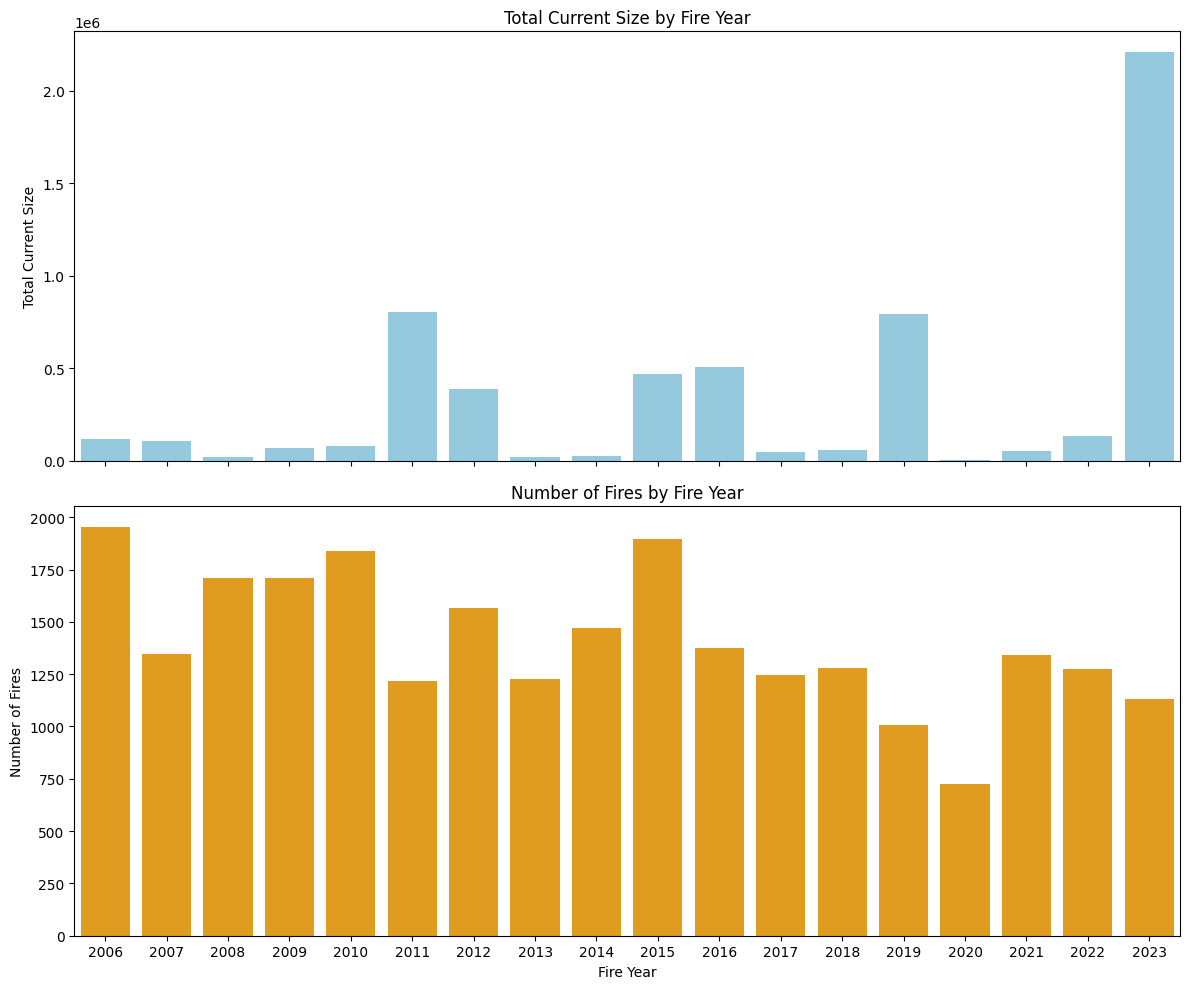

In [41]:
# Group by fire_year and calculate the mean current_size and count of items
grouped_df = data.groupby('fire_year').agg({'current_size': 'sum', 'size_class': 'count'}).reset_index()
grouped_df.rename(columns={'size_class': 'count'}, inplace=True)

# Convert fire_year to integer (ensure it's already integer in your original dataframe)
grouped_df['fire_year'] = grouped_df['fire_year'].astype(int)

# Display as a table
print("Comparison of Total Current Size and Number of Fires by Year:")
print(grouped_df)

# Create figure and axes
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# Bar plot for Total Current Size
sns.barplot(data=grouped_df, x='fire_year', y='current_size', ax=ax1, color='skyblue')
ax1.set_title('Total Current Size by Fire Year')
ax1.set_ylabel('Total Current Size')

# Bar plot for Number of Fires
sns.barplot(data=grouped_df, x='fire_year', y='count', ax=ax2, color='orange')
ax2.set_title('Number of Fires by Fire Year')
ax2.set_xlabel('Fire Year')
ax2.set_ylabel('Number of Fires')

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

There was a substantial increase in the total area burned in 2023, which surpassed the previously high totals recorded in 2011 and 2019. Despite this increase in fire size, the number of fires has been on a decreasing trend over the past years. The number of fires reached its lowest point in 2020, with the second lowest in 2017. Interestingly, although the area burned in 2023 was the highest, the number of fires that year was the third lowest in recent history. This suggests that while fewer fires are occurring, they tend to be larger and more destructive.

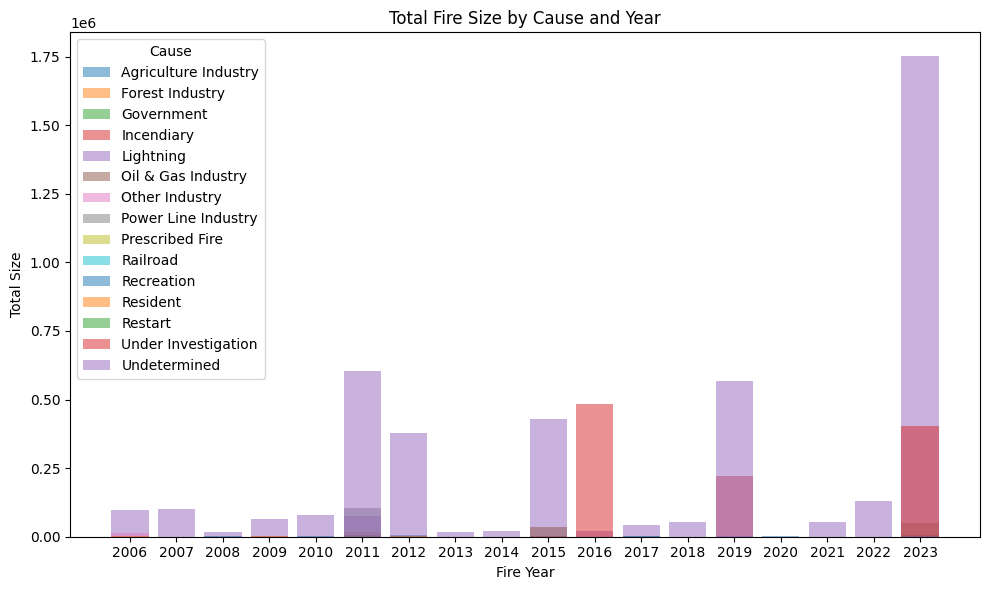

In [42]:
grouped_data = data.groupby(['general_cause_desc', 'fire_year'])['current_size'].sum().reset_index()

plt.figure(figsize=(10, 6)) 
# Iterate over unique general_cause_desc values for separate bars
for i, cause in enumerate(grouped_data['general_cause_desc'].unique()):
    plt.bar(
        grouped_data[grouped_data['general_cause_desc'] == cause]['fire_year'],
        grouped_data[grouped_data['general_cause_desc'] == cause]['current_size'],
        label=cause,
        alpha=0.5
    )

plt.xlabel('Fire Year')
plt.ylabel('Total Size')
plt.title('Total Fire Size by Cause and Year')
plt.xticks(grouped_data['fire_year'].unique())
plt.legend(title='Cause')

plt.tight_layout()
plt.show()


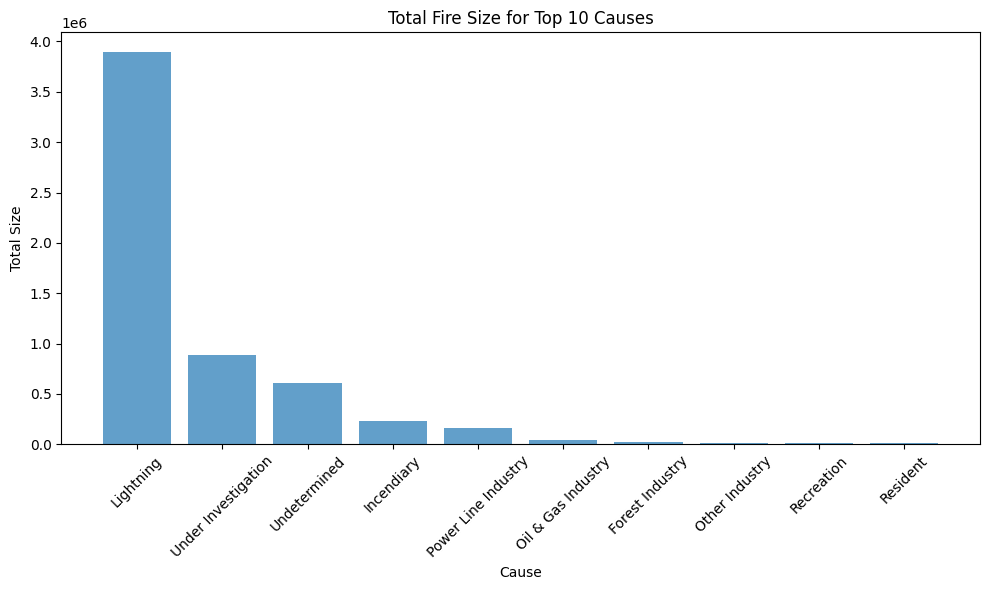

In [43]:
# Group by 'general_cause_desc' and sum the 'current_size' to get total size for each cause
total_size_by_cause = data.groupby('general_cause_desc')['current_size'].sum().reset_index()

# Identify the top 10 causes based on total size
top_5_causes = total_size_by_cause.nlargest(10, 'current_size')

# Plot the data for the top 10 causes
plt.figure(figsize=(10, 6))
plt.bar(top_5_causes['general_cause_desc'], top_5_causes['current_size'], alpha=0.7)

plt.xlabel('Cause')
plt.ylabel('Total Size')
plt.title('Total Fire Size for Top 10 Causes')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Basic Data Cleaning by Ray

In [44]:
data.shape

(25321, 52)

In [45]:
# Summary for missing values
# Adjusted code to display percentage of NA values for easier analysis

missing_summary = data.isna().sum()/len(data)*100

print("Summary of missing values for each column:")
print(missing_summary)

Summary of missing values for each column:
fire_year                        0.000000
fire_number                      0.000000
fire_name                       97.120967
current_size                     0.000000
size_class                       0.000000
fire_location_latitude           0.000000
fire_location_longitude          0.000000
fire_origin                      0.063189
general_cause_desc               0.000000
industry_identifier_desc        98.175428
responsible_group_desc          62.943802
activity_class                  38.596422
true_cause                      46.483156
fire_start_date                  2.689467
det_agent_type                   0.000000
det_agent                        0.000000
discovered_date                 19.513447
discovered_size                 99.423403
reported_date                    0.000000
dispatched_resource              0.067138
dispatch_date                    0.067138
start_for_fire_date              0.078986
assessment_resource              

In [46]:
# data.dropna()

In [47]:
columns_drop=[
'fire_year',                            # Redundant date column, the same information is available in the multiple other date columns. 
'fire_number',                          # useless column that is used as an indexing column
'fire_name',                            # 97.120967% missing values
'industry_identifier_desc',             # 98.175428% missing values
'true_cause',                           # 46.48% missing values
'ia_access',                            # 55.99% missing values
'activity_class',                       # 38.59% missing values
'discovered_size',                      # important column, but has 99% missing values
'responsible_group_desc',               # 62% missing values
'distance_from_water_source',           # 71.98% missing values
'first_bucket_drop_date',               # 71.97% missing values
'to_fs_date',                           # 89.55% missing values
'to_hectares'                           # 89.55% missing values
]
clean_na=data.drop(columns=columns_drop)

In [48]:
# Convert date columns to datetime
date_columns = ['fire_start_date', 
                'discovered_date', 
                'reported_date', 
                'start_for_fire_date', 
                'dispatch_date', 
                'assessment_datetime',
                'ia_arrival_at_fire_date', 
                'fire_fighting_start_date', 
                 'bh_fs_date', 
                 'uc_fs_date', 
                 'ex_fs_date']

# Convert each column to datetime
for col in date_columns:
    clean_na[col] = pd.to_datetime(clean_na[col], errors='coerce')

In [49]:
#Code column to binary for data analysis
clean_na['bucketing_on_fire']=clean_na['bucketing_on_fire'].map({'Y': 1, 'N': 0})

In [50]:
# droppping rows with NA values
clean_na.dropna(inplace=True)
clean_na.drop(clean_na[clean_na['fire_start_date'].dt.year.isin([2000, 2004, 2005])].index, inplace=True)    #discovered we have few rows for 2000, 2004, 2005 so I removed them as our analysis is from 2006-2023, and those points are about 5 rows

clean_na.shape

(11041, 39)

In [51]:
clean_na.dtypes

current_size                           float64
size_class                              object
fire_location_latitude                 float64
fire_location_longitude                float64
fire_origin                             object
general_cause_desc                      object
fire_start_date                 datetime64[ns]
det_agent_type                          object
det_agent                               object
discovered_date                 datetime64[ns]
reported_date                   datetime64[ns]
dispatched_resource                     object
dispatch_date                   datetime64[ns]
start_for_fire_date             datetime64[ns]
assessment_resource                     object
assessment_datetime             datetime64[ns]
assessment_hectares                    float64
fire_spread_rate                       float64
fire_type                               object
fire_position_on_slope                  object
weather_conditions_over_fire            object
temperature  

## Classification - KNN

In [52]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder


In [53]:
datetime_columns = clean_na.select_dtypes(include=['datetime64']).columns
for column in datetime_columns:
    clean_na[column + '_year'] = clean_na[column].dt.year
    clean_na[column + '_month'] = clean_na[column].dt.month
    clean_na[column + '_day'] = clean_na[column].dt.day
    clean_na[column + '_hour'] = clean_na[column].dt.hour
    clean_na = clean_na.drop(columns=[column])

In [54]:
label_encoders = {}
for column in clean_na.select_dtypes(include=['object']).columns:
    label_encoders[column] = LabelEncoder()
    clean_na[column] = label_encoders[column].fit_transform(clean_na[column])

In [55]:
clean_na.dtypes

current_size               float64
size_class                   int32
fire_location_latitude     float64
fire_location_longitude    float64
fire_origin                  int32
                            ...   
uc_fs_date_hour              int32
ex_fs_date_year              int32
ex_fs_date_month             int32
ex_fs_date_day               int32
ex_fs_date_hour              int32
Length: 72, dtype: object

In [56]:
# Separate the features (X) and the target (y)
X = clean_na.drop(columns = ['size_class'])
y = clean_na['size_class']
y = LabelEncoder().fit_transform(y)


# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [57]:
# Initialize the KNN classifier
knn = KNeighborsClassifier()

# To find the best k- value
# Define k- value range
param_grid = {'n_neighbors': range(1, 15)}

grid_search = GridSearchCV(knn, param_grid, cv=3)
grid_search.fit(X_train, y_train)

best_k = grid_search.best_params_['n_neighbors']
print(f"Best k value: {best_k}")

Best k value: 14


In [58]:
#Using the best k -value
best_knn = KNeighborsClassifier(n_neighbors=best_k)
best_knn.fit(X_train, y_train)

y_pred = best_knn.predict(X_test)

# Performance evluation
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)

Accuracy: 0.5613399728383884
Confusion Matrix:
[[847 284  11   5   4]
 [430 346   9   4   5]
 [ 39  94   7   2   5]
 [  5  21  18   5   4]
 [  9   4  11   5  35]]
Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.74      0.68      1151
           1       0.46      0.44      0.45       794
           2       0.12      0.05      0.07       147
           3       0.24      0.09      0.14        53
           4       0.66      0.55      0.60        64

    accuracy                           0.56      2209
   macro avg       0.42      0.37      0.39      2209
weighted avg       0.53      0.56      0.54      2209



Improvement

In [59]:
from sklearn.preprocessing import StandardScaler


In [60]:
# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
# Initialize the KNN classifier
knn = KNeighborsClassifier()

# To find the best k- value
# Define k- value range
param_grid = {'n_neighbors': range(1, 15)}

grid_search = GridSearchCV(knn, param_grid, cv=3)
grid_search.fit(X_train, y_train)

best_k = grid_search.best_params_['n_neighbors']
print(f"Best k value: {best_k}")

Best k value: 12


In [62]:
#Using the best k -value
best_knn = KNeighborsClassifier(n_neighbors=best_k)
best_knn.fit(X_train, y_train)

y_pred = best_knn.predict(X_test)

# Performance evluation
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)

Accuracy: 0.606156631960163
Confusion Matrix:
[[967 184   0   0   0]
 [444 344   6   0   0]
 [ 44  91  11   0   1]
 [ 13  28   8   1   3]
 [  8  28   8   4  16]]
Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.84      0.74      1151
           1       0.51      0.43      0.47       794
           2       0.33      0.07      0.12       147
           3       0.20      0.02      0.03        53
           4       0.80      0.25      0.38        64

    accuracy                           0.61      2209
   macro avg       0.50      0.32      0.35      2209
weighted avg       0.57      0.61      0.57      2209



## Time Series Analysis

In [63]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

### Time Series Analysis - "Current Size"

In [64]:
ts_data = clean_na.copy()

ts_data['fire_start_date'] = pd.to_datetime(
    ts_data[['start_for_fire_date_year', 'start_for_fire_date_month', 'start_for_fire_date_day']]
    .rename(columns={
        'start_for_fire_date_year': 'year',
        'start_for_fire_date_month': 'month',
        'start_for_fire_date_day': 'day'
    })
)

ts_data = ts_data[['fire_start_date','current_size']].copy()

# Set the fire_start_date as the index
ts_data.set_index('fire_start_date', inplace=True)
ts_data.sort_index(inplace=True)
ts_data = ts_data.resample('M').sum()

print(ts_data.head(10))

                 current_size
fire_start_date              
2006-04-30            2592.68
2006-05-31            3049.39
2006-06-30           85082.85
2006-07-31           20415.99
2006-08-31            1976.09
2006-09-30              52.34
2006-10-31             102.62
2006-11-30               0.03
2006-12-31               0.02
2007-01-31               0.90


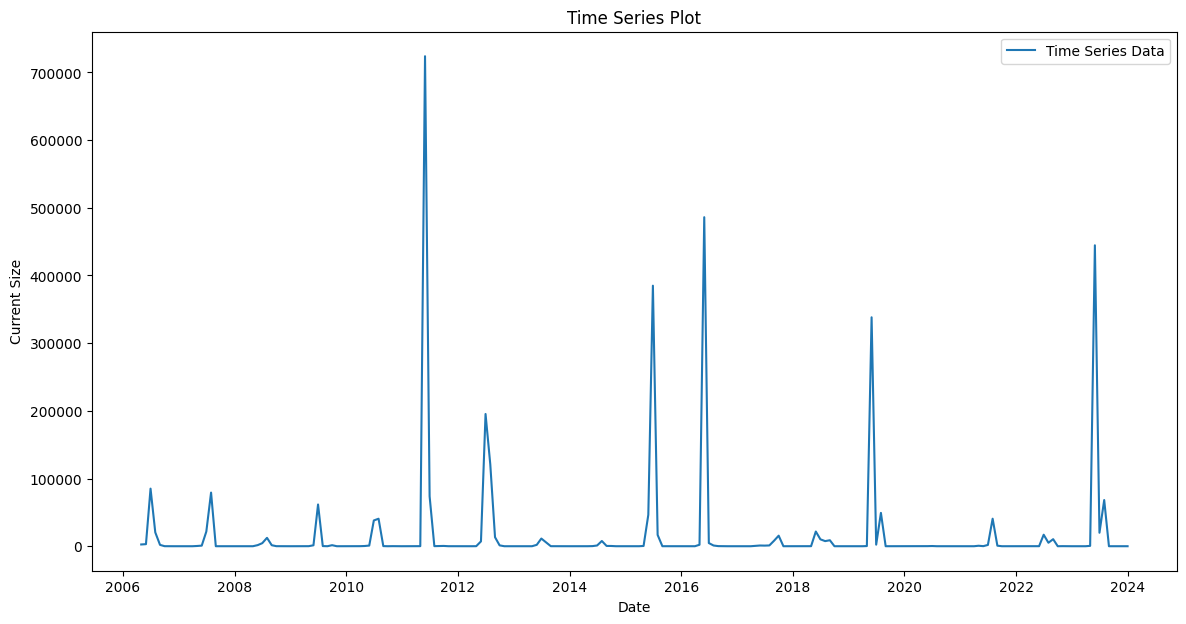

In [65]:
# Plot the time series
plt.figure(figsize=(14, 7))
plt.plot(ts_data.index, ts_data['current_size'], label='Time Series Data')
plt.title('Time Series Plot')
plt.xlabel('Date')
plt.ylabel('Current Size')
plt.legend()
plt.show()

In [70]:
# Stationery check
# Perform Augmented Dickey-Fuller test
result = adfuller(ts_data['current_size'])
print('ADF Statistic:', result[0])
print('p-value: {:.10f}'.format(result[1]))

for key, value in result[4].items():
    print('Critical Values:')
    print(f'   {key}, {value}')

print('p-value is less than a significance level of 0.05, reject the null hypothesis. The series is stationary')


ADF Statistic: -13.750985625318547
p-value: 0.0000000000
Critical Values:
   1%, -3.4615775784078466
Critical Values:
   5%, -2.875271898983725
Critical Values:
   10%, -2.5740891037735847
p-value is less than a significance level of 0.05, reject the null hypothesis. The series is stationary


<Figure size 1400x1000 with 0 Axes>

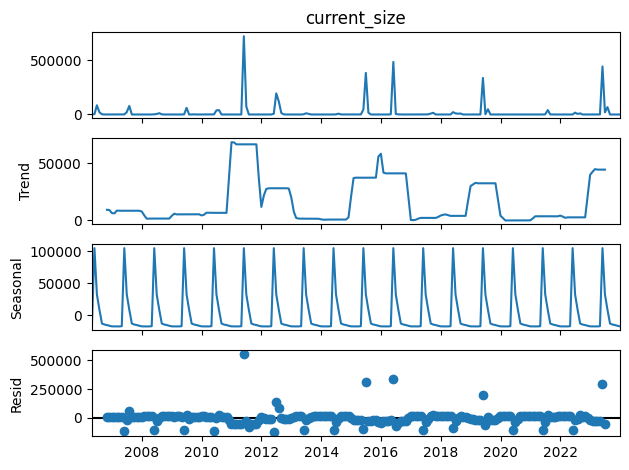

In [71]:
decomposition = seasonal_decompose(ts_data['current_size'], model='additive', period=12)
plt.figure(figsize=(14, 10))
decomposition.plot()
plt.show()


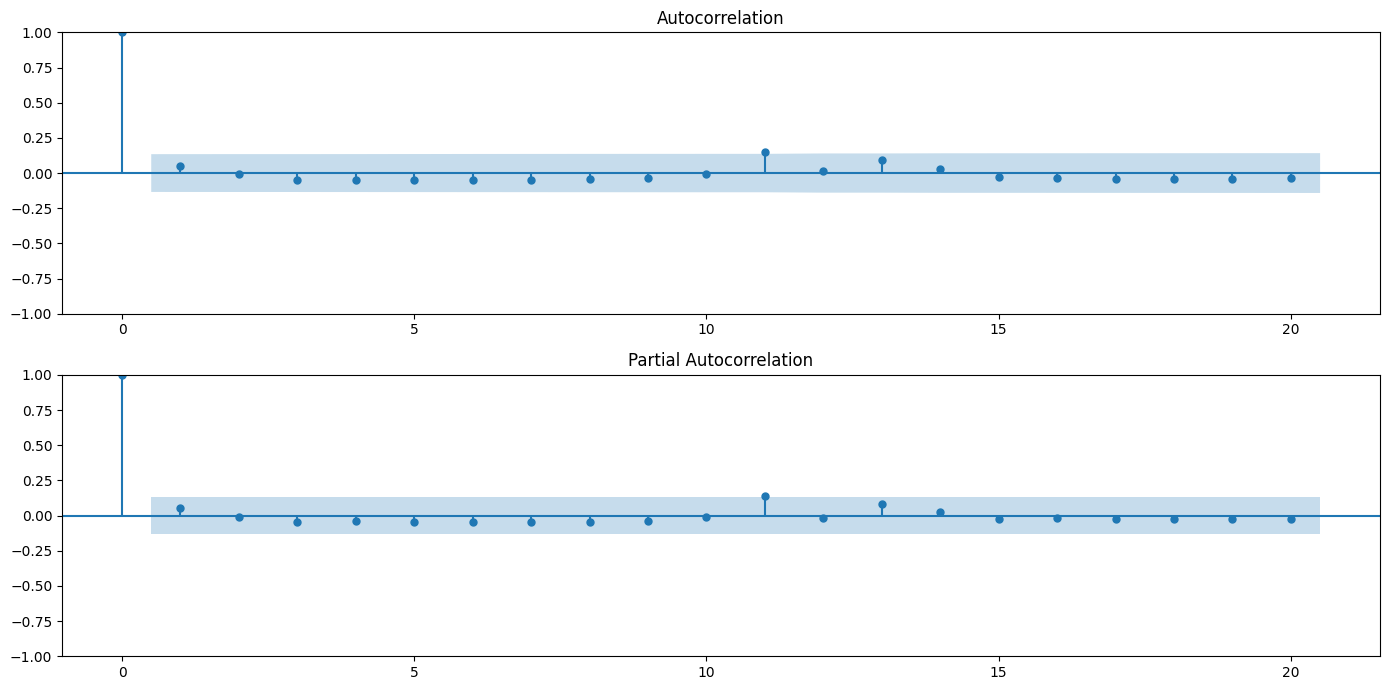

In [72]:
# Autocorrelation Function and Partial Autocorrelation Function 
plt.figure(figsize=(14, 7))

# ACF plot
ax1 = plt.subplot(211)
plot_acf(ts_data['current_size'], lags=20, ax=ax1)

# PACF plot
ax2 = plt.subplot(212)
plot_pacf(ts_data['current_size'], lags=20, ax=ax2)

plt.tight_layout()
plt.show()

In [73]:
# Fit SARIMA model
order = (1, 0, 1)  # (p, d, q)
seasonal_order = (1, 1, 0, 12)  # (P, D, Q, S) with S=12 for monthly data

sarima_model = SARIMAX(ts_data['current_size'], order=order, seasonal_order=seasonal_order)
sarima_model_fit = sarima_model.fit(disp=False)
print(sarima_model_fit.summary())

# Calculate RSS (Residual Sum of Squares)
residuals = sarima_model_fit.resid
rss = sum(residuals**2)

print(rss)

                                      SARIMAX Results                                      
Dep. Variable:                        current_size   No. Observations:                  213
Model:             SARIMAX(1, 0, 1)x(1, 1, [], 12)   Log Likelihood               -2590.267
Date:                             Wed, 26 Jun 2024   AIC                           5188.533
Time:                                     16:41:03   BIC                           5201.746
Sample:                                 04-30-2006   HQIC                          5193.880
                                      - 12-31-2023                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0887     13.673      0.006      0.995     -26.711      26.888
ma.L1         -0.0721     1

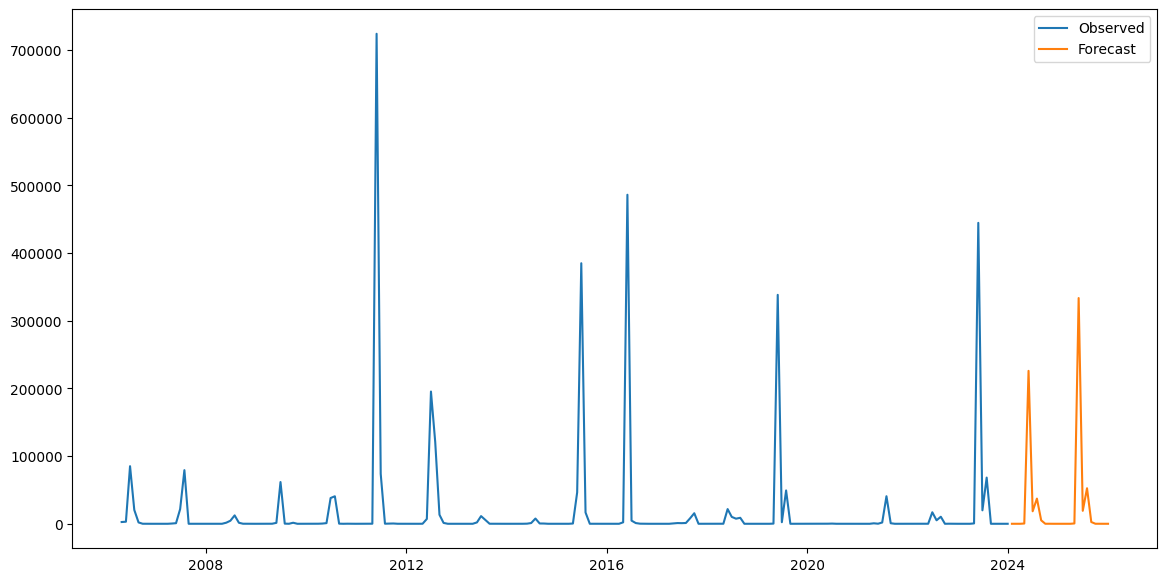

In [74]:
# Forecasting with the fitted SARIMA model for the next 2 years
forecast_steps = 24
forecast = sarima_model_fit.forecast(steps=forecast_steps)

# Plotting the forecast
plt.figure(figsize=(14, 7))
plt.plot(ts_data.index, ts_data['current_size'], label='Observed')
plt.plot(pd.date_range(start=ts_data.index[-1], periods=forecast_steps+1, freq='M')[1:], forecast, label='Forecast')
plt.legend()
plt.show()

### Time Series Analysis - Fire Count

In [75]:
ts_data_count = clean_na.copy()

ts_data_count['fire_start_date'] = pd.to_datetime(
    ts_data_count[['start_for_fire_date_year', 'start_for_fire_date_month', 'start_for_fire_date_day']]
    .rename(columns={
        'start_for_fire_date_year': 'year',
        'start_for_fire_date_month': 'month',
        'start_for_fire_date_day': 'day'
    })
)

ts_data_count['month_year'] = ts_data_count['fire_start_date'].dt.to_period('M')
ts_data_count = ts_data_count.groupby('month_year').size().reset_index(name='fire_count')
ts_data_count.set_index('month_year', inplace=True)
ts_data_count.sort_index(inplace=True)\
 
print(ts_data_count.head(10))

            fire_count
month_year            
2006-04            108
2006-05            134
2006-06            205
2006-07            362
2006-08             58
2006-09             52
2006-10             18
2006-11              3
2006-12              1
2007-01              2


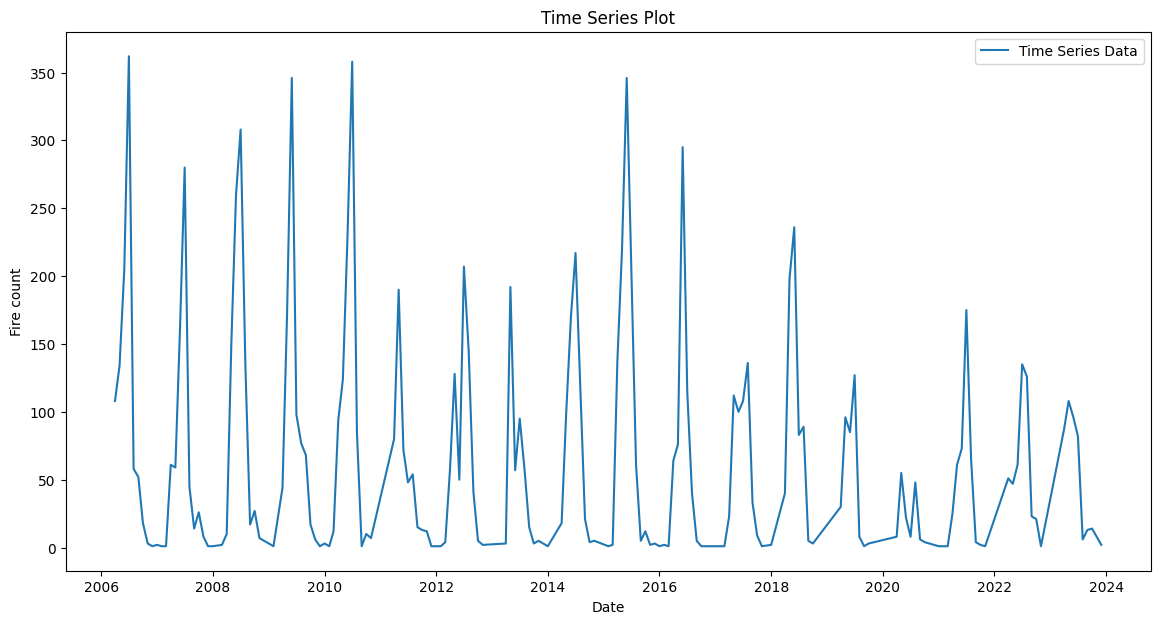

In [76]:
# Plot the time series
ts_data_count.index = ts_data_count.index.to_timestamp()

plt.figure(figsize=(14, 7))
plt.plot(ts_data_count.index, ts_data_count['fire_count'], label='Time Series Data')
plt.title('Time Series Plot')
plt.xlabel('Date')
plt.ylabel('Fire count')
plt.legend()
plt.show()

<Figure size 1400x1000 with 0 Axes>

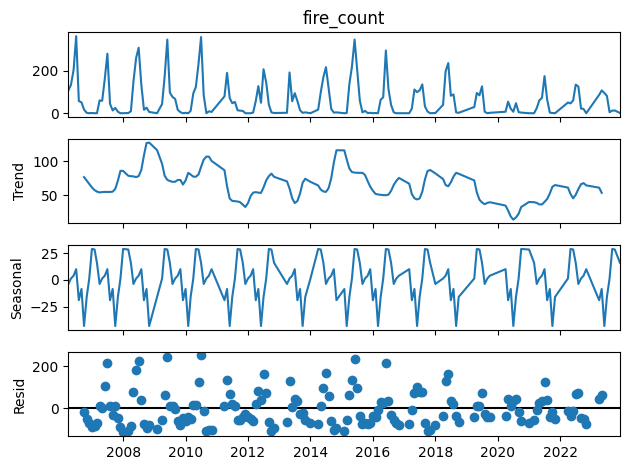

In [77]:
# Decomposing the Time Series
decomposition = seasonal_decompose(ts_data_count['fire_count'], model='additive', period=12)

plt.figure(figsize=(14, 10))
decomposition.plot()
plt.show()

In [78]:
# Perform ADF test for stationarity
result = adfuller(ts_data_count['fire_count'])

print('ADF Statistic:', result[0])
print('p-value:', result[1])

print('p-value is significantly lower than 0.05, indicating the data is stationary, we can proceed with SARIMA modeling without further differencing.')

ADF Statistic: -9.51053547453544
p-value: 3.258535393679427e-16
p-value is significantly lower than 0.05, indicating the data is stationary, we can proceed with SARIMA modeling without further differencing.


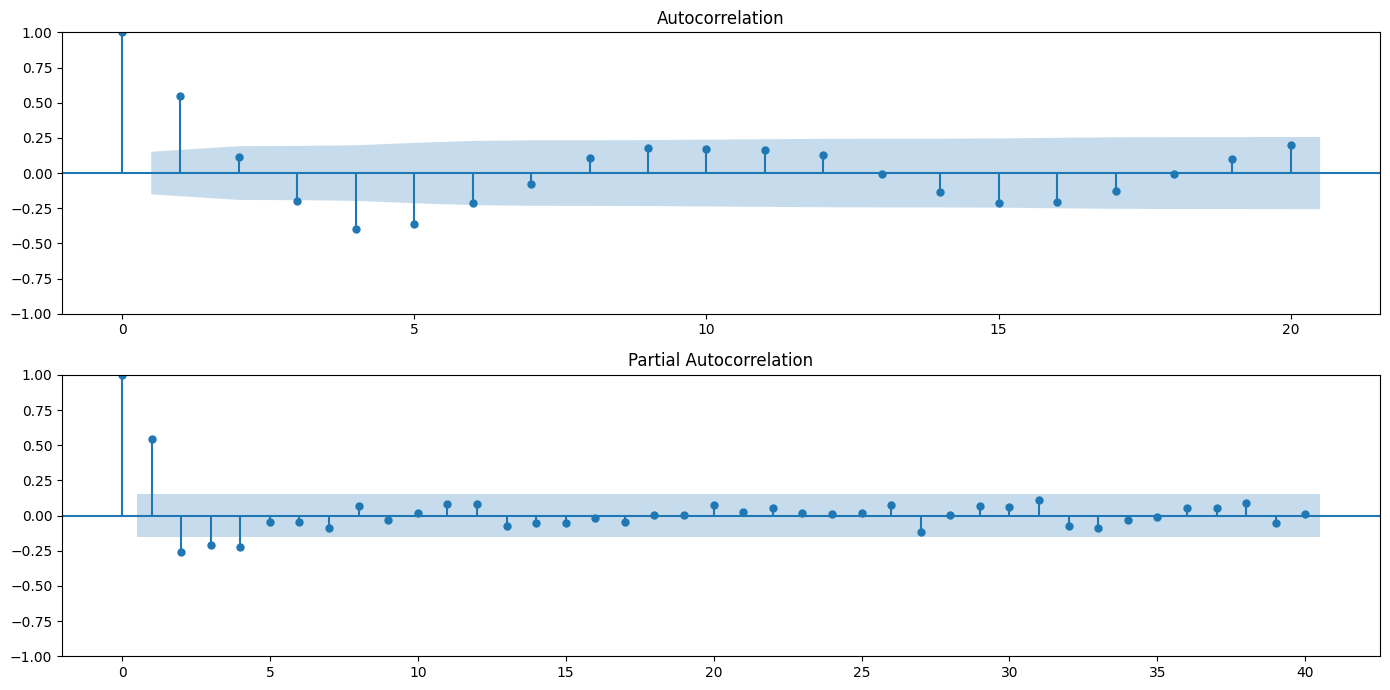

In [79]:
plt.figure(figsize=(14, 7))
# ACF plot
ax1 = plt.subplot(211)
plot_acf(ts_data_count['fire_count'], lags=20, ax=ax1)

# PACF plot
ax2 = plt.subplot(212)
plot_pacf(ts_data_count['fire_count'], lags=40, ax=ax2)

plt.tight_layout()

In [80]:
# SARIMA model fitting
countmodel = SARIMAX(ts_data_count['fire_count'], order=(1, 0, 1), seasonal_order=(1, 0, 1, 12))
countmodel_fit = countmodel.fit(disp=False)
print(countmodel_fit.summary())

C:\Users\gigic\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\gigic\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                         fire_count   No. Observations:                  168
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 12)   Log Likelihood                -954.981
Date:                            Wed, 26 Jun 2024   AIC                           1919.962
Time:                                    16:42:14   BIC                           1935.582
Sample:                                         0   HQIC                          1926.301
                                            - 168                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4611      0.114      4.028      0.000       0.237       0.685
ma.L1          0.2800      0.156   

C:\Users\gigic\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\gigic\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


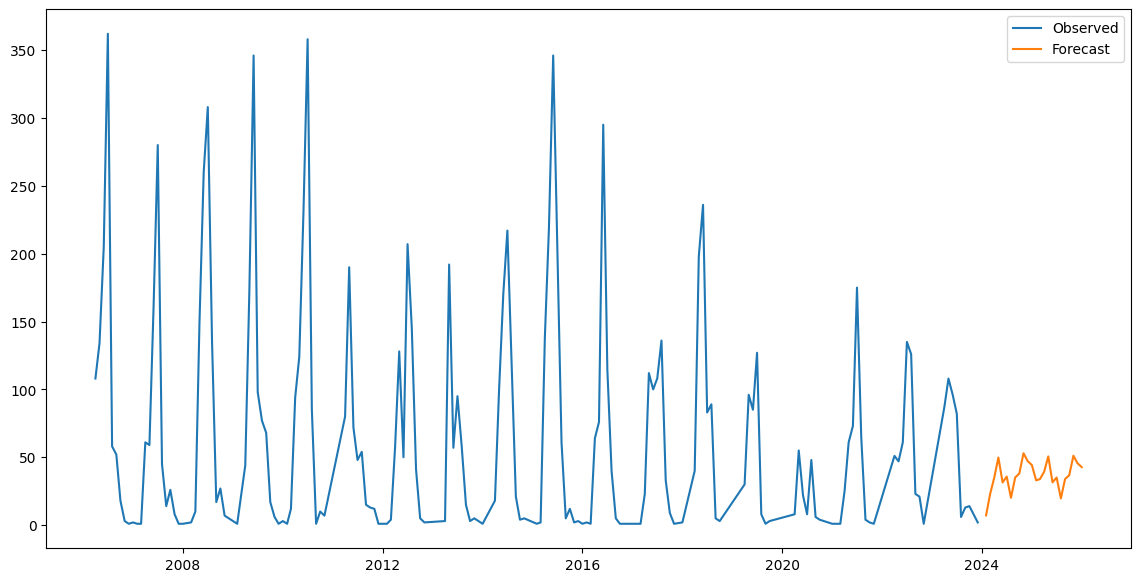

In [81]:
# Forecasting with the fitted SARIMA model for the next 2 years
forecast_steps = 24
forecast_count = countmodel_fit.forecast(steps=forecast_steps)

# Plotting the forecast
plt.figure(figsize=(14, 7))
plt.plot(ts_data_count.index, ts_data_count['fire_count'], label='Observed')
plt.plot(pd.date_range(start=ts_data_count.index[-1], periods=forecast_steps+1, freq='M')[1:], forecast_count, label='Forecast')
plt.legend()
plt.show()


In [ ]:
# Gigi's Notes:
# log transformation on the analysis on burned size?
# change of sarima parameter?

## SEDA

In [68]:
seda=clean_na

In [69]:



# Convert the latitude and longitude columns to a GeoDataFrame
geometry = [Point(xy) for xy in zip(seda['fire_location_longitude'], seda['fire_location_latitude'])]
wildfire_gdf = gpd.GeoDataFrame(seda, geometry=geometry)

# Set the coordinate reference system (CRS) to WGS84 (EPSG:4326)
wildfire_gdf.set_crs(epsg=4326, inplace=True)

# Extract year from 'fire_start_date' and get the unique years
seda['fire_start_date_year'] = seda['fire_start_date'].dt.year
unique_years = sorted(wildfire_gdf['fire_start_date_year'].unique())

# Determine the layout of subplots (e.g., 3 columns)
n_years = len(unique_years)
n_cols = 3
n_rows = math.ceil(n_years / n_cols)

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows), constrained_layout=True)
axes = axes.flatten()  # Flatten the 2D array of axes to a 1D array for easier indexing

# Plot wildfire points for each year in a subplot
for i, year in enumerate(unique_years):
    yearly_data = wildfire_gdf[wildfire_gdf['fire_start_date_year'] == year]
    
    ax = axes[i]
    yearly_data.plot(ax=ax, marker='o', color='red', markersize=5, label='Wildfires')
    ax.set_title(f'Wildfires in {year}')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.legend()

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.show()

KeyError: 'fire_start_date'

## ANN

In [ ]:
ann_data=clean_na

In [ ]:

# Identify categorical and numerical columns
categorical_columns = ann_data.select_dtypes(include=['object']).columns
numerical_columns = ann_data.select_dtypes(include=[np.number]).columns

# Handle missing values
for column in numerical_columns:
    ann_data[column].fillna(ann_data[column].median(), inplace=True)

for column in categorical_columns:
    ann_data[column].fillna(ann_data[column].mode()[0], inplace=True)

# Encode categorical variables
label_encoders = {}
for column in categorical_columns:
    le = LabelEncoder()
    ann_data[column] = le.fit_transform(ann_data[column])
    label_encoders[column] = le

# Drop datetime columns
datetime_columns = ann_data.select_dtypes(include=['datetime64']).columns
ann_data.drop(columns=datetime_columns, inplace=True)

# Extract features and target variable
X = ann_data.drop(columns=['size_class'])
y = ann_data['size_class']

# Encode target variable
le_target = LabelEncoder()
y = le_target.fit_transform(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the numerical features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define the neural network architecture
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, num_classes):
        super(NeuralNetwork, self).__init__()
        self.layer1 = nn.Linear(input_size, 128)
        self.layer2 = nn.Linear(128, 64)
        self.layer3 = nn.Linear(64, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.layer1(x)
        out = self.relu(out)
        out = self.layer2(out)
        out = self.relu(out)
        out = self.layer3(out)
        return out

# Initialize the model, loss function, and optimizer
input_size = X_train.shape[1]
num_classes = len(le_target.classes_)
model = NeuralNetwork(input_size, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 20
for epoch in range(num_epochs):
    for X_batch, y_batch in train_loader:
        # Forward pass
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluate the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        _, predicted = torch.max(outputs.data, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()

    accuracy = 100 * correct / total
    print(f'Accuracy of the model on the test set: {accuracy:.2f}%')

### ANN with VIF to remove highly collinear features. 

In [ ]:


# Identify categorical and numerical columns
categorical_columns = ann_data.select_dtypes(include=['object']).columns
numerical_columns = ann_data.select_dtypes(include=[np.number]).columns

# Handle missing values
for column in numerical_columns:
    ann_data[column].fillna(ann_data[column].median(), inplace=True)

for column in categorical_columns:
    ann_data[column].fillna(ann_data[column].mode()[0], inplace=True)

# Encode categorical variables
label_encoders = {}
for column in categorical_columns:
    le = LabelEncoder()
    ann_data[column] = le.fit_transform(ann_data[column])
    label_encoders[column] = le

# Drop datetime columns
datetime_columns = ann_data.select_dtypes(include=['datetime64']).columns
ann_data.drop(columns=datetime_columns, inplace=True)

# Extract features and target variable
X = ann_data.drop(columns=['size_class'])
y = ann_data['size_class']

# Encode target variable
le_target = LabelEncoder()
y = le_target.fit_transform(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Function to calculate VIF
def calculate_vif(df):
    vif = pd.DataFrame()
    vif["Feature"] = df.columns
    vif["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return vif

# Calculate VIF before handling multicollinearity
vif_before = calculate_vif(pd.DataFrame(X_train, columns=X.columns))
print(vif_before)

# Drop features with high VIF (e.g., VIF > 10)
features_to_drop = vif_before[vif_before['VIF'] > 10]['Feature']
X_train_reduced = X_train.drop(columns=features_to_drop)
X_test_reduced = X_test.drop(columns=features_to_drop)

# Recalculate VIF after dropping features
vif_after = calculate_vif(pd.DataFrame(X_train_reduced, columns=X_train_reduced.columns))
print(vif_after)

# Proceed with scaling and neural network construction using reduced features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_reduced)
X_test_scaled = scaler.transform(X_test_reduced)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define the neural network architecture
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, num_classes):
        super(NeuralNetwork, self).__init__()
        self.layer1 = nn.Linear(input_size, 128)
        self.layer2 = nn.Linear(128, 64)
        self.layer3 = nn.Linear(64, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.layer1(x)
        out = self.relu(out)
        out = self.layer2(out)
        out = self.relu(out)
        out = self.layer3(out)
        return out

# Initialize the model, loss function, and optimizer
input_size = X_train_reduced.shape[1]
num_classes = len(le_target.classes_)
model = NeuralNetwork(input_size, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 20
for epoch in range(num_epochs):
    for X_batch, y_batch in train_loader:
        # Forward pass
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluate the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        _, predicted = torch.max(outputs.data, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()

    accuracy = 100 * correct / total
    print(f'Accuracy of the model on the test set: {accuracy:.2f}%')

In [ ]:
ann_data['size_class'].value_counts()

We have class imbalance, so we need to adjust our code to sample equally using SMOTE

In [ ]:

# Identify categorical and numerical columns
categorical_columns = ann_data.select_dtypes(include=['object']).columns
numerical_columns = ann_data.select_dtypes(include=[np.number]).columns

# Handle missing values
for column in numerical_columns:
    ann_data[column].fillna(ann_data[column].median(), inplace=True)

for column in categorical_columns:
    ann_data[column].fillna(ann_data[column].mode()[0], inplace=True)

# Encode categorical variables
label_encoders = {}
for column in categorical_columns:
    le = LabelEncoder()
    ann_data[column] = le.fit_transform(ann_data[column])
    label_encoders[column] = le

# Drop datetime columns
datetime_columns = ann_data.select_dtypes(include=['datetime64']).columns
ann_data.drop(columns=datetime_columns, inplace=True)

# Extract features and target variable
X = ann_data.drop(columns=['size_class'])
y = ann_data['size_class']

# Encode target variable
le_target = LabelEncoder()
y = le_target.fit_transform(y)

# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X, y = smote.fit_resample(X, y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Function to calculate VIF
def calculate_vif(df):
    vif = pd.DataFrame()
    vif["Feature"] = df.columns
    vif["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return vif

# Calculate VIF before handling multicollinearity
vif_before = calculate_vif(pd.DataFrame(X_train, columns=X.columns))
print(vif_before)

# Drop features with high VIF (e.g., VIF > 10)
features_to_drop = vif_before[vif_before['VIF'] > 10]['Feature']
X_train_reduced = X_train.drop(columns=features_to_drop)
X_test_reduced = X_test.drop(columns=features_to_drop)

# Recalculate VIF after dropping features
vif_after = calculate_vif(pd.DataFrame(X_train_reduced, columns=X_train_reduced.columns))
print(vif_after)

# Proceed with scaling and neural network construction using reduced features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_reduced)
X_test_scaled = scaler.transform(X_test_reduced)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define the neural network architecture
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, num_classes):
        super(NeuralNetwork, self).__init__()
        self.layer1 = nn.Linear(input_size, 256)
        self.layer2 = nn.Linear(256, 128)
        self.layer3 = nn.Linear(128, 64)
        self.layer4 = nn.Linear(64, num_classes)
        self.dropout = nn.Dropout(0.3)
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.layer1(x)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.layer2(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.layer3(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.layer4(out)
        return out

# Initialize the model, loss function, and optimizer with L2 regularization
input_size = X_train_reduced.shape[1]
num_classes = len(le_target.classes_)
model = NeuralNetwork(input_size, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)  # L2 regularization

# Train the model with early stopping
num_epochs = 50
patience = 5
best_loss = float('inf')
trigger_times = 0

for epoch in range(num_epochs):
    model.train()
    for X_batch, y_batch in train_loader:
        # Forward pass
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()
    
    val_loss /= len(test_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}')
    
    # Early stopping
    if val_loss < best_loss:
        best_loss = val_loss
        trigger_times = 0
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print('Early stopping!')
            break

# Evaluate the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        _, predicted = torch.max(outputs.data, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()

    accuracy = 100 * correct / total
    print(f'Accuracy of the model on the test set: {accuracy:.2f}%')

L2 regularization without using SMOTE

In [ ]:


# Identify categorical and numerical columns
categorical_columns = ann_data.select_dtypes(include=['object']).columns
numerical_columns = ann_data.select_dtypes(include=[np.number]).columns

# Handle missing values
for column in numerical_columns:
    ann_data[column].fillna(ann_data[column].median(), inplace=True)

for column in categorical_columns:
    ann_data[column].fillna(ann_data[column].mode()[0], inplace=True)

# Encode categorical variables
label_encoders = {}
for column in categorical_columns:
    le = LabelEncoder()
    ann_data[column] = le.fit_transform(ann_data[column])
    label_encoders[column] = le

# Drop datetime columns
datetime_columns = ann_data.select_dtypes(include=['datetime64']).columns
ann_data.drop(columns=datetime_columns, inplace=True)

# Extract features and target variable
X = ann_data.drop(columns=['size_class'])
y = ann_data['size_class']

# Encode target variable
le_target = LabelEncoder()
y = le_target.fit_transform(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Function to calculate VIF
def calculate_vif(df):
    vif = pd.DataFrame()
    vif["Feature"] = df.columns
    vif["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return vif

# Calculate VIF before handling multicollinearity
vif_before = calculate_vif(pd.DataFrame(X_train, columns=X.columns))
print(vif_before)

# Drop features with high VIF (e.g., VIF > 10)
features_to_drop = vif_before[vif_before['VIF'] > 10]['Feature']
X_train_reduced = X_train.drop(columns=features_to_drop)
X_test_reduced = X_test.drop(columns=features_to_drop)

# Recalculate VIF after dropping features
vif_after = calculate_vif(pd.DataFrame(X_train_reduced, columns=X_train_reduced.columns))
print(vif_after)

# Proceed with scaling and neural network construction using reduced features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_reduced)
X_test_scaled = scaler.transform(X_test_reduced)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define the neural network architecture
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, num_classes):
        super(NeuralNetwork, self).__init__()
        self.layer1 = nn.Linear(input_size, 256)
        self.layer2 = nn.Linear(256, 128)
        self.layer3 = nn.Linear(128, 64)
        self.layer4 = nn.Linear(64, num_classes)
        self.dropout = nn.Dropout(0.3)
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.layer1(x)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.layer2(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.layer3(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.layer4(out)
        return out

# Initialize the model, loss function, and optimizer with L2 regularization
input_size = X_train_reduced.shape[1]
num_classes = len(le_target.classes_)
model = NeuralNetwork(input_size, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)  # L2 regularization

# Train the model with early stopping
num_epochs = 50
patience = 5
best_loss = float('inf')
trigger_times = 0

for epoch in range(num_epochs):
    model.train()
    for X_batch, y_batch in train_loader:
        # Forward pass
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()
    
    val_loss /= len(test_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}')
    
    # Early stopping
    if val_loss < best_loss:
        best_loss = val_loss
        trigger_times = 0
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print('Early stopping!')
            break

# Evaluate the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        _, predicted = torch.max(outputs.data, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()

    accuracy = 100 * correct / total
    print(f'Accuracy of the model on the test set: {accuracy:.2f}%')
